# Distribution by age groups of hepatitis of unknown origin in children in Europe

> Max Pierini (EpiData.it)

***

We want to fit the distribution by age groups of hepatitis of unknown origin in children in Europe to a function that can properly describe the data.

We'll need a probability function $f(x)$ for positive real values of $x$, i.e. $x \in \mathbb{R}^+$. For this reason we'll try fit the data to 3 distributions

1. **Gamma** distribution, whose Probability Density Function (PDF) is

$$
\mathrm{Gamma}(x; s, r) = \frac{r^s x^{s-1} e^{-rx}}{\Gamma(s)}
$$

where $s>0$ and $r>0$ are respectively *shape* and *rate* parameters ($\alpha=s$ and $\beta=1/r$) and $\Gamma$ is the Gamma function;

2. **Weibull** distribution, whose PDF is

$$
\mathrm{Weibull}(x; s, r) = s r x^{s-1} \exp(-r x^s)
$$

where $s>0$ and $r>0$ are respectively *shape* and *rate* parameters;

3. **Log-normal** distribution, whose PDF is

$$
\mathrm{LogNorm}(x; \mu, \tau) = \frac{\sqrt{\frac{\tau}{2\pi}}}{x} \exp\left( -\frac{1}{2} \tau \big( \log(x) - \mu \big)^2 \right)
$$

where $\mu$ and $\tau>0$ are respectively *mean* and *precision* ($\sigma^2 = 1/\tau$).

We'll use a Markov Chain Monte Carlo (MCMC) to estimate parameters and Goodness-of-Fit Statistics (GoFS) and we'll choose the distribution whose parameters' estimation minimizes GoFS.

We'll define a simple MCMC in `JAGS` and use `pyjags` and `arviz` to run the model, import results and plot diagnostics and parameters' estimation.

***

First of all, let's import needed packages

In [1]:
import numpy as np
import pandas as pd
import pyjags
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from IPython.display import Markdown

download the data

In [2]:
df = pd.read_csv(
    "https://github.com/fbranda/hepatitis/raw/main/ECDC-WHO_Regional_Office_for_Europe/age_cases_latest.csv"
)

visualize them

In [3]:
df

,age,cases
0,0,42
1,1,51
2,2,52
3,3,98
4,4,67
5,5,50
6,6,20
7,7,17
8,8,15
9,9,13


and plot them as a first Exploratory Data Analysis (EDA)

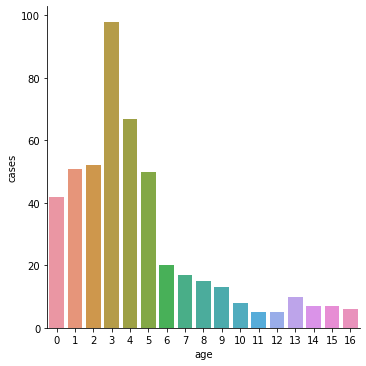

In [4]:
sns.catplot(
    data=df,
    kind="bar",
    x="age", y="cases"
);

We need to note a few things:

- age groups' names are categoris and are defined by the left edge of the bin so that, for example, group "0" means between 0 (included) and 1 (excluded) years old, i.e. $[0,1)$. The same for all $g$ age groups $[g, g+1)$. Thus, to properly fit the data we'll need to change the group names to bin center adding 0.5 years;

- we have got the counts for each age group but not the data to be fitted, so we'll need to generate the data given the counts

Let's generate the data (adjusting the age groups' names)

In [5]:
data = np.array([])
for age, count in zip(df.age.values, df.cases.values):
    _data = np.repeat(age+0.5, count)
    data = np.concatenate([data, _data])

In [6]:
np.unique(data)

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

and define the model: we'll distribute each observation as Gamma, Weibull or Log-normal distributed, choosing uninformative priors for distributions' parameters, than compute Sum of Squares Error (SSE) within the MCMC itself to choose the best fitting distribution.

!["MCMC model"](hepatits_model.drawio.png)

In [7]:
model_string = """
model {
    for(i in 1:N){
        gamma_y[i] ~ dgamma(gamma_shape, gamma_rate)
        weib_y[i] ~ dweib(weib_shape, weib_rate)
        lnorm_y[i] ~ dlnorm(lnorm_mu, lnorm_tau)
    }
    
    # parameters' priors

    gamma_shape ~ dgamma(0.01, 0.01)
    gamma_rate ~ dgamma(0.01, 0.01)
    
    weib_shape ~ dgamma(0.01, 0.01)
    weib_rate ~ dgamma(0.01, 0.01)
    
    lnorm_mu ~ dnorm(0, 1)
    lnorm_tau ~ dgamma(0.01, 0.01)
    
    # GoFS and PDFs

    gamma_pdf <- dgamma(ages, gamma_shape, gamma_rate) * N
    gamma_SSE <- sum( (counts - gamma_pdf)^2 )
    gamma_PDF <- dgamma(x, gamma_shape, gamma_rate) * N
    
    weib_pdf <- dweib(ages, weib_shape, weib_rate) * N
    weib_SSE <- sum( (counts - weib_pdf)^2 )
    weib_PDF <- dweib(x, weib_shape, weib_rate) * N
    
    lnorm_pdf <- dlnorm(ages, lnorm_mu, lnorm_tau) * N
    lnorm_SSE <- sum( (counts - lnorm_pdf)^2 )
    lnorm_PDF <- dlnorm(x, lnorm_mu, lnorm_tau) * N
}
"""

Let's now define model data

In [8]:
model_data = {
    "gamma_y": data,
    "weib_y": data,
    "lnorm_y": data,
    "N": data.size,
    "ages": df.age.values+.5,
    "counts": df.cases.values,
    "x": np.linspace(0, 17, 100)
}

init the model

In [9]:
model = pyjags.Model(
    code=model_string,
    data=model_data,
    adapt=1000,
    chains=4
)

adapting: iterations 4000 of 4000, elapsed 0:00:06, remaining 0:00:00
adapting: iterations 4000 of 4000, elapsed 0:00:06, remaining 0:00:00


and run the MCMC with 6000 iterations per chain (1000 warmup)

In [10]:
sample = model.sample(
    1000 + 5000,
    vars=[
        "gamma_shape", "gamma_rate", "gamma_SSE", "gamma_PDF",
        "weib_shape", "weib_rate", "weib_SSE", "weib_PDF",
        "lnorm_mu", "lnorm_tau", "lnorm_SSE", "lnorm_PDF",
    ]
)

sampling: iterations 5384 of 24000, elapsed 0:00:08, remaining 0:00:28
sampling: iterations 8764 of 24000, elapsed 0:00:13, remaining 0:00:23
sampling: iterations 12112 of 24000, elapsed 0:00:18, remaining 0:00:18
sampling: iterations 15452 of 24000, elapsed 0:00:24, remaining 0:00:13
sampling: iterations 22020 of 24000, elapsed 0:00:34, remaining 0:00:03
sampling: iterations 24000 of 24000, elapsed 0:00:37, remaining 0:00:00


Now we can extract `JAGS`-*coda* results with arviz

In [11]:
az_data = az.from_pyjags(sample,
    warmup_iterations=1000, save_warmup=False)

and plot traces

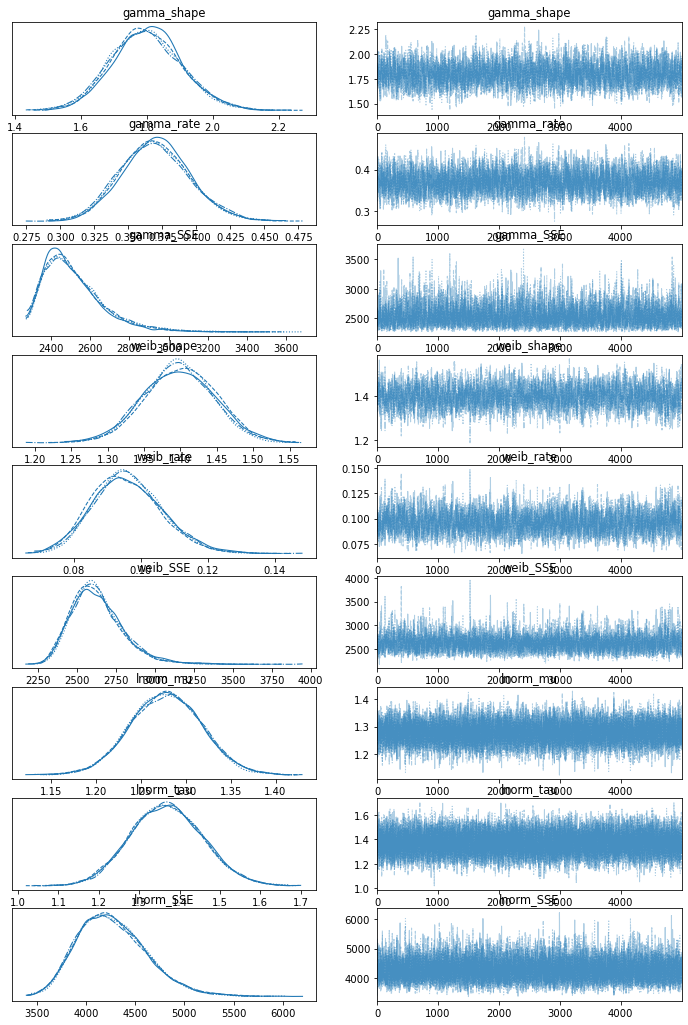

In [12]:
az.plot_trace(
    az_data, 
    var_names=[
        "gamma_shape", "gamma_rate", "gamma_SSE",
        "weib_shape", "weib_rate", "weib_SSE",
        "lnorm_mu", "lnorm_tau", "lnorm_SSE"
    ],
);

print the summary

In [13]:
pars = az.summary(
    az_data, hdi_prob=.99,
    var_names=[
        "gamma_shape", "gamma_rate", "gamma_SSE",
        "weib_shape", "weib_rate", "weib_SSE",
        "lnorm_mu", "lnorm_tau", "lnorm_SSE"
    ], kind='stats', stat_funcs=[np.median])

In [14]:
pars

,mean,sd,hdi_0.5%,hdi_99.5%,median
gamma_shape,1.799,0.106,1.530,2.084,1.797
gamma_rate,0.370,0.025,0.304,0.434,0.369
gamma_SSE,2515.776,155.702,2269.951,3021.195,2483.733
weib_shape,1.398,0.048,1.274,1.523,1.398
weib_rate,0.096,0.010,0.072,0.124,0.095
weib_SSE,2631.036,167.607,2285.000,3159.568,2610.253
lnorm_mu,1.278,0.040,1.175,1.384,1.278
lnorm_tau,1.368,0.088,1.146,1.593,1.367
lnorm_SSE,4274.146,356.093,3496.205,5317.616,4239.376


plot the posteriors

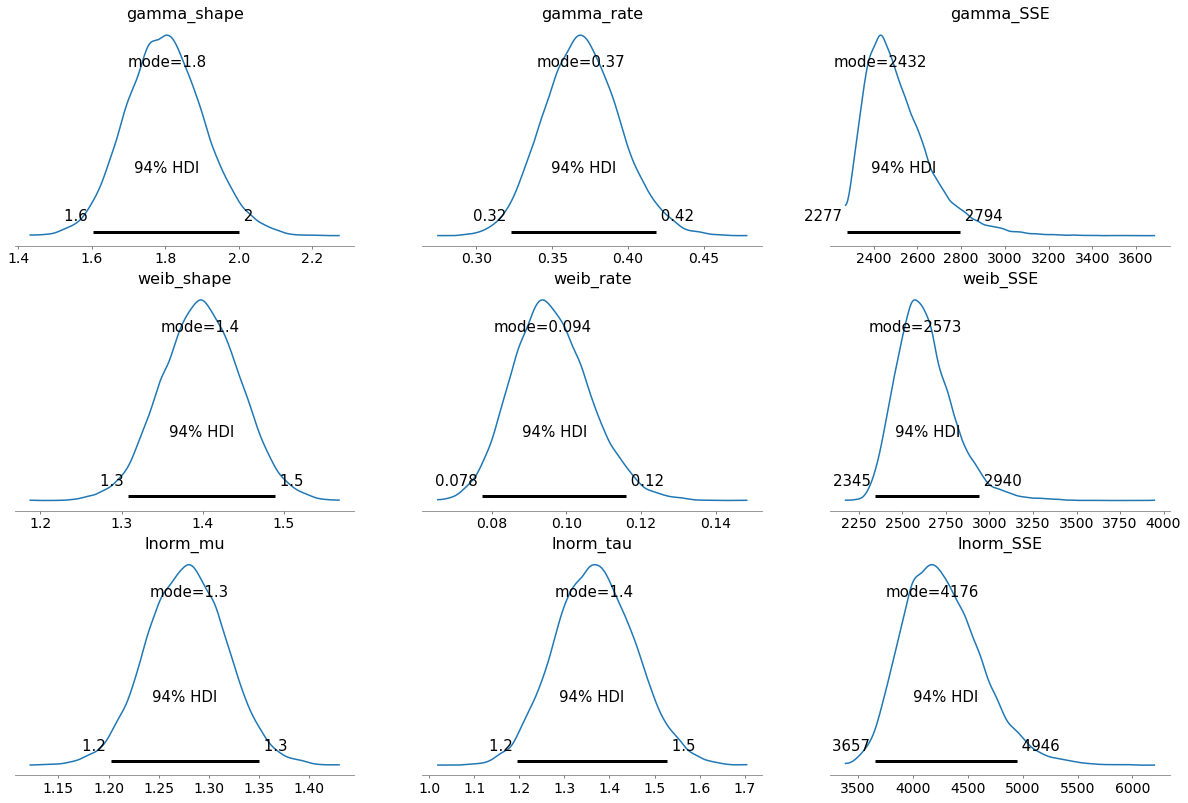

In [15]:
az.plot_posterior(az_data, var_names=[
        "gamma_shape", "gamma_rate", "gamma_SSE",
        "weib_shape", "weib_rate", "weib_SSE",
        "lnorm_mu", "lnorm_tau", "lnorm_SSE"
    ],
    point_estimate="mode"
);

and choose the best distribution by looking at SSE posteriors

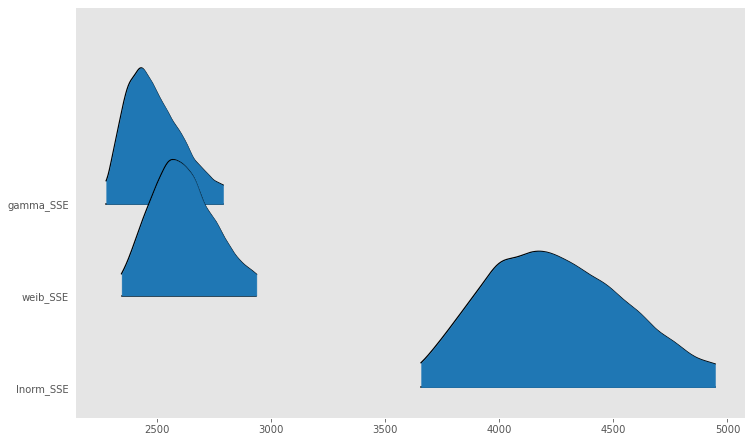

In [16]:
with plt.style.context("ggplot"):
    az.plot_forest(
        az_data, 
        kind="ridgeplot",
        combined=True,
        var_names=["gamma_SSE", "weib_SSE", "lnorm_SSE"]
    );

In [17]:
gamma_pdf = az.summary(
    az_data, hdi_prob=.99,
    var_names=[
        "gamma_PDF",
    ], kind='stats', stat_funcs=[np.median])

In [18]:
gamma_pdf.set_index(model_data["x"], inplace=True)

In [19]:
weib_pdf = az.summary(
    az_data, hdi_prob=.99,
    var_names=[
        "weib_PDF",
    ], kind='stats', stat_funcs=[np.median])

In [20]:
weib_pdf.set_index(model_data["x"], inplace=True)

In [21]:
lnorm_pdf = az.summary(
    az_data, hdi_prob=.99,
    var_names=[
        "lnorm_PDF",
    ], kind='stats', stat_funcs=[np.median])

In [22]:
lnorm_pdf.set_index(model_data["x"], inplace=True)

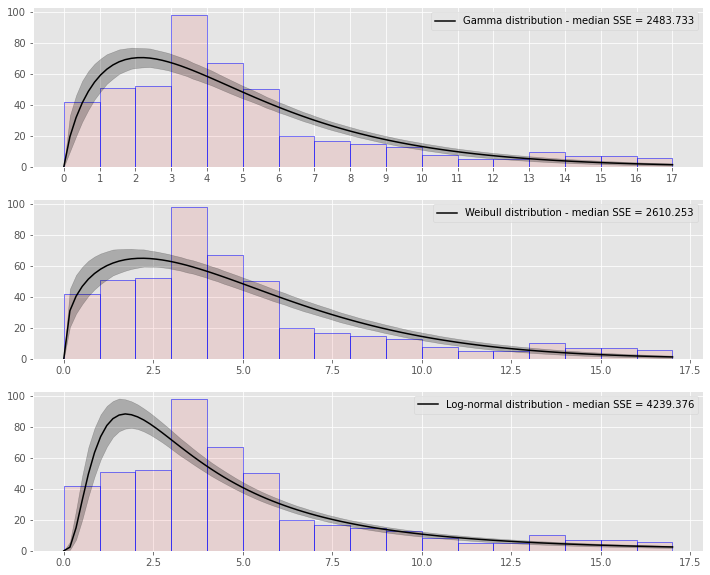

In [23]:
with plt.style.context("ggplot"):

    df1 = df.copy(deep=True)
    df1.age = df.index+.5

    fig, ax = plt.subplots(3, 1, figsize=(12, 10))

    ax[0].bar(df.age, df.cases, width=1, align="edge", edgecolor='blue', color=(0.9, 0.1, 0.1, 0.1))
    gamma_pdf.plot(y="median", color="k", label=f"Gamma distribution - median SSE = {pars['median'].gamma_SSE}", ax=ax[0])
    ax[0].fill_between(
        gamma_pdf.index,
        gamma_pdf["hdi_0.5%"], gamma_pdf["hdi_99.5%"],
        alpha=.25, color="k"
    )
    ax[0].set_xticks(np.arange(0,18))

    ax[1].bar(df.age, df.cases, width=1, align="edge", edgecolor='blue', color=(0.9, 0.1, 0.1, 0.1))
    weib_pdf.plot(y="median", color="k", label=f"Weibull distribution - median SSE = {pars['median'].weib_SSE}", ax=ax[1])
    ax[1].fill_between(
        weib_pdf.index,
        weib_pdf["hdi_0.5%"], weib_pdf["hdi_99.5%"],
        alpha=.25, color="k"
    )

    ax[2].bar(df.age, df.cases, width=1, align="edge", edgecolor='blue', color=(0.9, 0.1, 0.1, 0.1))

    lnorm_pdf.plot(y="median", color="k", label=f"Log-normal distribution - median SSE = {pars['median'].lnorm_SSE}", ax=ax[2])
    ax[2].fill_between(
        lnorm_pdf.index,
        lnorm_pdf["hdi_0.5%"], lnorm_pdf["hdi_99.5%"],
        alpha=.25, color="k"
    )

Finally, we can say the best distribution is **Gamma** with parameters

In [24]:
pars.iloc[:2]

,mean,sd,hdi_0.5%,hdi_99.5%,median
gamma_shape,1.799,0.106,1.530,2.084,1.797
gamma_rate,0.370,0.025,0.304,0.434,0.369


***

This model should be implemented with more powerful MCMC packages, such as `Stan`, and use more reliable model-selection-stats such as log-likelihood, WAIC, WBIC etc.